Charities:
- GiveDirectly
- Against Malaria Foundation

Spread: 95% of AMF's CE estimates lie within 529.3491365825378% percent of the central estimate.
Spread: 95% of GD's CE estimates lie within 71.1875810680964% percent of the central estimate.


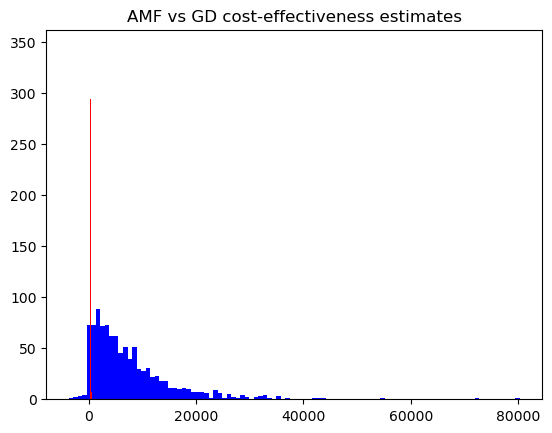

It took 1.0309607982635498 seconds to run 10000 runs and plot the cost-effectiveness graph.


In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns # density plots 
import math as m
import time # how long does it take to run

"""
Remarks:
- norm(), lognorm(), present_value(): not sure if correctly coded, just get close enough to squiggle, but prob. wrong since CE output not as broad (even if central est. right)
- probability-like values: replace lognorm() with beta() , rewrite lognorm() to be just >0
- amf(): maybe refactor to take out stuff like data (malaria, population) and modeling PV future income increase (maybe general?)
- moral inputs: need to loop them too, else won't sample from dist. What's the right way to code this? 
"""

# useful functions
def utility(consumption):
    utils = m.log(consumption, m.e)
    return utils

def present_value(present_value, discount_rate, time):
    q = 1 - pow(1 - discount_rate, time)
    r = m.log(1 - discount_rate, m.e)
    result = -present_value * q / r

    return result

def normalize(numbers):
	total = sum(numbers)
	normalized = [num / total for num in numbers]
	return normalized

def norm(mean, stdev, bound=''):
	norm_raw = float(np.random.normal(mean,stdev,1))
	
	if bound == 'probability': 
		norm = min(1, max(0, norm_raw)) 
		
	else:
		norm = norm_raw

	return norm

def lognorm(mean, stdev, bound=''):
	norm_raw = m.log(float(np.random.lognormal(mean,stdev,1)), m.e)
	
	if bound == 'probability': 
		norm = min(1, max(0, norm_raw)) 

	elif bound == 'discount': # hacky, can't be zero else divide-by-zero error. Should probably be the same as 'else' below?
		norm = max(0.00001, norm_raw)
		
	else: # default always positive, no upper bound 
		norm = max(0, norm_raw) 

	return norm

def spread(data, spread=95):
	lower = (100 - spread) / 2
	upper = 100 - lower

	center_data = round(np.percentile(data, 50), 0)
	lower_data_normed = round(np.percentile(data, lower) / center_data, 2)
	upper_data_normed = round(np.percentile(data, upper) / center_data, 2)

	return spread, lower_data_normed, upper_data_normed, center_data


# cost-effectiveness modeling of charities
# givedirectly
def gd(donation_size=100000):
	# inputs 
	grant_per_household = norm(1000, 50)
	transfer_efficiency = lognorm(0.83, 0.05, 'probability')
	household_size = max(1, lognorm(4.7, 0.5)) # households can't have <1 person. stdev from amateurish eyeballing in Squiggle to match Sam's peak
	consumption_baseline = lognorm(285.92, 5)
	portion_invested = lognorm(0.39,0.04, 'probability')
	portion_investment_returned = 0.2 # Sam says not important, would remove 
	negative_spillover = lognorm(0.95,0.05, 'probability') # 5% discount in ln(consumption)
	roi = lognorm(0.1, 0.03)
	discount_rate = lognorm(0.04, 0.01, 'discount') # shared with AMF
	# duration_investment = 10 # years. No distribution in Sam's notebook?
	duration_investment = max(1, m.log(float(np.random.lognormal(10,4,1)),m.e))
	duration_investment = max(1, lognorm(10, 4)) # investment should be >= 1 year
	duration_initial_consumption = 1 # implicit in GW model. replace with a distribution?

	# calculated from inputs
	amount_transferred = donation_size * transfer_efficiency
	num_households = amount_transferred / grant_per_household
	grant_per_person = grant_per_household / household_size # per person is detached from transfer efficiency
	amount_invested = grant_per_person * portion_invested
	amount_consumed = grant_per_person * (1 - portion_invested)

	value_initial_consumption = (utility((consumption_baseline + (amount_consumed / duration_initial_consumption))) - utility(consumption_baseline)) * duration_initial_consumption
	value_from_roi = utility((consumption_baseline + (amount_invested * roi))) - utility(consumption_baseline)
	value_from_investment = present_value(value_from_roi, discount_rate, (duration_investment - 1))
	consumption_final_year = consumption_baseline + amount_invested * (roi + portion_investment_returned)
	value_resale = (utility(consumption_final_year) - utility(consumption_baseline)) / pow(1 + discount_rate, duration_investment)

	value_per_person = value_from_investment + value_resale + value_initial_consumption
	value_per_person_inc_spillover = value_per_person * negative_spillover
	value_per_household = value_per_person_inc_spillover * household_size # also independent of transfer efficiency
	
	value_total = value_per_household * num_households # transfer efficiency comes in here: more households get grants

	value_2x_consumption = utility(consumption_baseline*2) - utility(consumption_baseline)
	value_total_2x_consumption = value_total / value_2x_consumption

	return value_total_2x_consumption

# against malaria foundation
def amf(donation_size=100000): # enter default donation sizes used in GW models 
	# inputs. Reference: Tanae Rao's Squiggle https://observablehq.com/d/a444c74425bdd968 and GW original https://docs.google.com/spreadsheets/d/1yEhDHEUjphHIZpLfCIs-kC9AOWCvqzVXA0To1zRNoKQ/edit#gid=1364064522 
	
	# moral inputs -- need to put into plot's for-loop (Markov)?
	value_life_under_5 = 116 # GW tab https://docs.google.com/spreadsheets/d/1yEhDHEUjphHIZpLfCIs-kC9AOWCvqzVXA0To1zRNoKQ/edit#gid=1362437801
	value_life_older = 73 # ditto. value of 1 = doubling consumption for one person for one year 
	discount_rate_income = lognorm(0.04, 0.01, 'discount')
	duration_income = lognorm(40, 4) # dubious -- would many in SSA want to and can work >40 years?
	multiplier_household_resource_sharing = lognorm(2.0, 0.2) # shared with deworming. Income benefits for earner's household members
	value_ln_consumption = 1 / utility(2)

	# charity data
	portion_spending_amf = norm(0.4979, 0.0441, 'probability')# hacky. from GW
	num_people_per_net = lognorm(1.8, 0.2) # arbitrary stdev, ~10% of mean
	cost_per_net = lognorm(4.99, 0.41)# hacky. from GW
	effective_coverage_yrs_per_person = lognorm(2.11, 0.2) # arbitrary stdev, 10% of mean
	delay_net_to_income = float(np.random.uniform(3,17,1)) # get net at 0-14, start working at 17 https://docs.google.com/document/d/1NxN6SO8GNv1AhpHMy1-IGu-tStT7py29W8AFU0u_bLw/edit?ts=599b4840

	# malaria & population data
	mortality_reduction_nets_under_5 = lognorm(0.17, 0.04, 'probability') # nets prevent 17% of deaths (Pryce 2018 meta analysis). stdev=4% from Squiggle 
	mortality_reduction_portion_malaria = lognorm(0.25, 0.05, 'probability') # isn't this nets *and* SMC? Why did GW call this nets? 
	mortality_under_5_2004 = lognorm(26.3, 6.3) # technically stdev=6.3 not accurate. I got it using =STDEV() in GW's gsheet, which isn't the same as lognorm stdev. But close enough?
	mortality_under_5_2019 = lognorm(13.1, 4.6) # see above 
	deaths_averted_smc = lognorm(0.41, 0.39) # see above 
	ratio_deaths_older_vs_under_5 = lognorm(0.67, 0.54) # see above
	relative_efficacy_nets_for_older = lognorm(0.8, 0.08) # see above
	income_increase_avert_malaria_under_14 = lognorm(0.023, 0.05)
	malaria_prevalence_reduction_under_5 = lognorm(0.45, 0.04) # Pryce meta analysis
	malaria_prevalence_under_5 = lognorm(0.26, 0.09) # GBD Results Tool at https://vizhub.healthdata.org/gbd-results?params=gbd-api-2019-permalink/b9af3b390f1060821ff8f97e63e184b4
	malaria_prevalence_5_to_14 = lognorm(0.28, 0.10) # ditto
	malaria_prevalence_increase_no_nets = lognorm(0.20, 0.05) # GW calc here https://docs.google.com/spreadsheets/d/1fWIfaVaTKZX53mBrB9_EdT8EUsk1Q58h7XsuNj8YyJE/edit#gid=1052575435

	pct_pop_under_5_raw = norm(0.1646, 0.0184, 'probability')
	pct_pop_5_to_14_raw = norm(0.2819, 0.0135, 'probability')
	pct_pop_older_raw = norm(0.5535, 0.0313, 'probability')
	pct_pop_under_5, pct_pop_5_to_14, pct_pop_older = normalize([pct_pop_under_5_raw, pct_pop_5_to_14_raw, pct_pop_older_raw]) # the sample above won't sum to 1

	# adjustments to raw cost-effectiveness estimate
	adjustment_charity_amf = lognorm(0.91, 0.05, 'probability') # Will they use the donation as intended? stdev is a guess
	adjustment_insecticide_resistance = lognorm(0.24, 0.164, 'probability') # technically stdev=0.164 not accurate. I got it using =STDEV() in GW's gsheet, which isn't the same as lognorm stdev. But close enough?
	adjustment_amf_vs_cochrane_areas = lognorm(1.002, 0.494) # see above 
	adjustment_misc = lognorm(0.789, 0.08)  # see above 
	adjustment_malaria_to_income_replicability = lognorm(0.52, 0.05, 'probability')

	# calculated from inputs
	# nets coverage
	total_spending_by_all_contributors = donation_size / portion_spending_amf
	cost_per_person = cost_per_net / num_people_per_net
	
	num_people_covered = total_spending_by_all_contributors / cost_per_person
	num_people_covered_under_5 = num_people_covered * pct_pop_under_5
	num_people_covered_5_to_14 = num_people_covered * pct_pop_5_to_14
	person_yrs_coverage_under_5 = num_people_covered_under_5 * effective_coverage_yrs_per_person
	person_yrs_coverage_5_to_14 = num_people_covered_5_to_14 * effective_coverage_yrs_per_person
	person_yrs_coverage_under_14 = person_yrs_coverage_under_5 + person_yrs_coverage_5_to_14

	# deaths averted
	mortality_drop_total = mortality_under_5_2019 - mortality_under_5_2004
	mortality_drop_malaria = mortality_drop_total * mortality_reduction_portion_malaria
	mortality_drop_nets_only = mortality_drop_malaria - deaths_averted_smc
	mortality_baseline = mortality_under_5_2019 + mortality_drop_nets_only # what if they didn't have nets?

	deaths_averted_per_1k_person_yrs_coverage_under_5_unadjusted = mortality_baseline * mortality_reduction_nets_under_5 
	deaths_averted_per_1k_person_yrs_coverage_under_5 = deaths_averted_per_1k_person_yrs_coverage_under_5_unadjusted * (1 - adjustment_insecticide_resistance) * adjustment_amf_vs_cochrane_areas * adjustment_misc
	deaths_averted_total_under_5 = deaths_averted_per_1k_person_yrs_coverage_under_5 * (person_yrs_coverage_under_5 / 1000.0)
	deaths_averted_total_older = deaths_averted_total_under_5 * ratio_deaths_older_vs_under_5 * relative_efficacy_nets_for_older
	deaths_averted_total = deaths_averted_total_under_5 + deaths_averted_total_older

	value_deaths_averted_under_5 = deaths_averted_total_under_5 * value_life_under_5
	value_deaths_averted_older = deaths_averted_total_older * value_life_older
	value_deaths_averted = value_deaths_averted_under_5 + value_deaths_averted_older

	# income increase
	malaria_prevalence_reduction_expected = malaria_prevalence_reduction_under_5 * (1 - adjustment_insecticide_resistance) * adjustment_amf_vs_cochrane_areas * adjustment_misc
	malaria_prevalence_baseline_under_5 = malaria_prevalence_under_5 * (1 + malaria_prevalence_increase_no_nets)
	malaria_prevalence_baseline_5_to_14 = malaria_prevalence_5_to_14 * (1 + malaria_prevalence_increase_no_nets)
	pct_reduction_covered_under_5 = malaria_prevalence_baseline_under_5 * malaria_prevalence_reduction_expected
	pct_reduction_covered_5_to_14 = malaria_prevalence_baseline_5_to_14 * malaria_prevalence_reduction_expected
	num_people_avert_malaria_under_5 = person_yrs_coverage_under_5 * pct_reduction_covered_under_5
	num_people_avert_malaria_5_to_14 = person_yrs_coverage_5_to_14 * pct_reduction_covered_5_to_14

	benefit_income_avert_malaria = adjustment_malaria_to_income_replicability * (utility(1+income_increase_avert_malaria_under_14) - utility(1))
	benefit_income_delay_discounted = benefit_income_avert_malaria / pow(1 + discount_rate_income, delay_net_to_income)
	pv_benefit_avert_malaria_1_person_under_14 = present_value(benefit_income_delay_discounted, discount_rate_income, duration_income)
	# present_value(present_value, discount_rate, time)
	pv_benefit_avert_malaria_under_14 = pv_benefit_avert_malaria_1_person_under_14 * multiplier_household_resource_sharing
	
	increase_ln_consumption_under_5 = pv_benefit_avert_malaria_under_14 * num_people_avert_malaria_under_5
	increase_ln_consumption_5_to_14 = pv_benefit_avert_malaria_under_14 * num_people_avert_malaria_5_to_14
	value_development = (increase_ln_consumption_under_5 + increase_ln_consumption_5_to_14) * value_ln_consumption

	# total value = deaths averted + income increased
	value_total_unadjusted = value_deaths_averted + value_development
	value_total = value_total_unadjusted * adjustment_charity_amf

	return value_total

charities = {
	'GiveDirectly' : gd(),
	'AMF' : amf()
}

# def plot_charities(donation_size=100000, runs=10000):
# 	start = time.time()

# 	title = 'Cost-effectiveness of'

# 	for charity in charities.keys():
# 		ce_estimates = []

# 		for run in range(runs):
# 			ce_estimates.append(charities[charity])

# 		most, lower_data_normed, upper_data_normed, center_data = spread(ce_estimates)
# 		print(f"{most}% of this charity's CE estimates lie between {lower_data_normed}x and {upper_data_normed}x of the central estimate of {center_data} utils per $100k.")

# 		plt.hist(ce_estimates, bins = 100, color = 'b')
# 		title += charity

# 	plt.title(title)
# 	plt.show()

# 	end = time.time()
# 	runtime = end - start
# 	print(f"It took {runtime} seconds to run {runs} runs and plot the cost-effectiveness graph.")

# 	return None

# plots
def plot_charities(donation_size=100000, runs=10000):
	start = time.time()
	
	data_gd = []
	data_amf = []

	for i in range(runs):
		data_gd.append(gd())
		# data_amf.append(amf())

	for j in range(1000):
		data_amf.append(amf())

	# percentiles
	# for percentile in [5, 50, 95]:
	# 	print(str(percentile) + "th percentile:", np.percentile(data_amf, percentile))

	spread_amf = 100 * (np.percentile(data_amf, 97.5) - np.percentile(data_amf, 2.5)) / np.percentile(data_amf, 50)
	spread_gd = 100 * (np.percentile(data_gd, 97.5) - np.percentile(data_gd, 2.5)) / np.percentile(data_gd, 50) 
	print(f"Spread: 95% of AMF's CE estimates lie within {spread_amf}% percent of the central estimate.")
	print(f"Spread: 95% of GD's CE estimates lie within {spread_gd}% percent of the central estimate.")

	# for charity_data in [data_gd, data_amf]:
	# 	most, lower_data_normed, upper_data_normed, center_data = spread(charity_data)
	# 	print(f"{most}% of this charity's CE estimates lie between {lower_data_normed}x and {upper_data_normed}x of the central estimate of {center_data} utils per $100k.")

	# # plots
	# # title = "A donation of $" + str(donation_size) + " is this many times as good as doubling recipient consumption for a year.\nThis should really be a probability density chart; the y-axis doesn't make sense here."
	title = "AMF vs GD cost-effectiveness estimates"
	plt.hist(data_amf, bins = 100, color = 'b')
	plt.hist(data_gd, bins = 100, color = 'r')
	plt.title(title)
	plt.show()

	end = time.time()
	runtime = end - start
	# print("It took", runtime, "seconds to run", runs, "runs and plot the cost-effectiveness graph.")
	print(f"It took {runtime} seconds to run {runs} runs and plot the cost-effectiveness graph.")

	return None

plot_charities()
